In [1]:
import numpy as np
import pandas as pd
from glob import glob
import librosa as lr
import matplotlib.pyplot as plt
import os
import csv
import tensorflow as tf

In [2]:
audio_dir = './Training_Data'

In [6]:
def initialize_files():
    global names,audio_files
    names = os.listdir(audio_dir) #gets the folders in the audio directory
    audio_files = {} 
    for key in names:
        audio_files[key] = glob(audio_dir + '/' + key + '/*.wav')
        if len(audio_files[key]) == 0:
            print ("Empty Folder or wrong Key_name usage : " + key)
    print (names)

In [4]:
def plotting(x, y, x_label = "x-axis", y_label = "y_axis", title = "",type = ''):
    fig, ax = plt.subplots()
    ax.plot(x,y)
    ax.set(xlabel = x_label, ylabel = y_label)
    fig.suptitle(title, fontsize=12)
    plt.show()

In [5]:
def spectral_flatness(signal):
    return lr.feature.spectral_flatness(signal)

def spectral_bandwidth(signal,sr):
    return lr.feature.spectral_bandwidth(signal,sr)

def mfcc(audio,sr,n):
    return lr.feature.mfcc(y = audio,sr = sr,n_mfcc = n)

def spectral_centroid(signal,sr):
    return lr.feature.spectral_centroid(signal,sr)

def rms(signal):
    return lr.feature.rms(signal)


In [21]:
def silence_finder(signal,sr):
    silences = []
    no_frames = len(signal)
    #print (no_frames)
    frame = 100
    start_frame = 0
    threshold = np.mean(signal)*0.5 #this value can be changed to optimize the algorithm
    while True:
        while True:
            area_under_observation = signal[start_frame:frame]
            
            if np.mean(area_under_observation) <= threshold and len(area_under_observation) / sr >= 1  :
                silences.append([start_frame,frame])
                #print (silences[-1])
                if silences[-1][1] == start_frame - 1 :
                    silences[-1] == [silences[-1][0],frame]
                    print (silences[-1])
                start_frame = frame + 100
                frame += 200 
                break
            elif np.mean(area_under_observation) <= threshold :
                frame += 10
                if frame >= no_frames :
                    break
            elif np.mean(area_under_observation) > threshold:
                #print ('I am Here : ' + str(frame))
                start_frame = frame + 100
                frame += 200  
                if frame >= no_frames :
                    break
        if frame >= no_frames :
            break
    return silences

In [ ]:
def region_of_interest (signal,silences,sr):
    rois = []
    start = 0
    for x in range(len(silences)+1):
        if x == len(silences) :
            roi = signal[start: len(signal)]
            rois.append(roi)
            break
        roi = signal[start: silences[x][0]]
        start = silences[x][1]
        rois.append(roi)
        
    return rois

In [44]:
def data_set(file_name,impulses):
    with open(file_name,'w') as Train_Data:
        filewriter= csv.writer(Train_Data)
        filewriter.writerow(["IMPULSE","MFCC_1","MFCC_2","MFCC_3","MFCC_4","MFCC_5","MFCC_6","MFCC_7","MFCC_8","MFCC_9","MFCC_10","Spec_Flat","Spec_Band","Spec_Cent"])
        count = 0
        for impulse in impulses:
            for file in impulses[impulse]:
                print (impulse,file,count)
                signal,sr = lr.load(file)
                time = len(signal) / sr
                for y in range(1,int(time/0.1)+1):
                    w = signal[int((y-1)*sr*0.1):int(y*sr*0.1)]
                    mfcc_final = np.zeros((13,1))
                    time_roi = len(w) / sr
                    if time_roi != 0:
                        mfccs = mfcc(w,sr,10)
                        for x in range(10):
                            if time_roi != 0:
                                mfcc_final[x] += ((np.sum(mfccs[x],keepdims = True))/time_roi)
                        mfcc_final[10] += (np.sum(spectral_flatness(w),keepdims = False))/time_roi
                        mfcc_final[11] += (np.sum(spectral_bandwidth(w,sr),keepdims = False))/time_roi
                        mfcc_final[12] += (np.sum(spectral_centroid(w,sr),keepdims = False))/time_roi
                        count += 1
                        mfcc_list = list(float(x.tolist()[0]) for x in mfcc_final)
                        data_entry = [impulse] + mfcc_list
                        filewriter.writerow(data_entry)
                        #print (data_entry)
                    

In [47]:
initialize_files()

['GUN', 'SCREAM']


In [48]:
data_set('Training_Data.csv',audio_files)

GUN ./Training_Data/GUN\GUN (1).wav 0
GUN ./Training_Data/GUN\GUN (10).wav 17
GUN ./Training_Data/GUN\GUN (11).wav 429
GUN ./Training_Data/GUN\GUN (12).wav 469
GUN ./Training_Data/GUN\GUN (13).wav 509
GUN ./Training_Data/GUN\GUN (14).wav 549
GUN ./Training_Data/GUN\GUN (15).wav 589
GUN ./Training_Data/GUN\GUN (16).wav 1219
GUN ./Training_Data/GUN\GUN (17).wav 1259
GUN ./Training_Data/GUN\GUN (18).wav 1319
GUN ./Training_Data/GUN\GUN (19).wav 1332
GUN ./Training_Data/GUN\GUN (2).wav 1357
GUN ./Training_Data/GUN\GUN (20).wav 1548
GUN ./Training_Data/GUN\GUN (21).wav 1593
GUN ./Training_Data/GUN\GUN (22).wav 1630
GUN ./Training_Data/GUN\GUN (23).wav 1651
GUN ./Training_Data/GUN\GUN (24).wav 1678
GUN ./Training_Data/GUN\GUN (25).wav 1699
GUN ./Training_Data/GUN\GUN (26).wav 1718
GUN ./Training_Data/GUN\GUN (3).wav 1911
GUN ./Training_Data/GUN\GUN (4).wav 1957
GUN ./Training_Data/GUN\GUN (5).wav 1980
GUN ./Training_Data/GUN\GUN (6).wav 2025
GUN ./Training_Data/GUN\GUN (8).wav 2043
GUN ./Tra

In [49]:
train_set = pd.read_csv('Training_Data.csv')
train_set = train_set.sample(frac=1).reset_index(drop=True)
train_set.head(10)

,IMPULSE,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,Spec_Flat,Spec_Band,Spec_Cent
0,SCREAM,-5503.389648,4734.797852,-4840.340332,-2509.562500,-938.133301,-504.976166,677.930420,1038.375488,759.145874,-84.835144,0.253282,84237.951642,90871.305755
1,GUN,-1478.193359,3961.011230,-776.240662,1690.508301,503.274597,470.896912,-216.135178,-122.197227,-491.153778,-49.658566,3.015208,125052.288460,128903.050514
2,GUN,-8795.548828,6052.129883,-1414.654175,1601.821289,1087.689819,578.500366,-113.451492,-45.460640,-685.966797,-211.144485,0.575104,100416.128049,85700.752960
3,SCREAM,-12746.298828,4886.538574,-3151.257324,-2385.682617,-30.489548,-69.105675,162.371368,300.508179,34.138317,388.835449,0.507639,104689.635887,100419.770130
4,SCREAM,-7921.001953,6064.285645,-9638.480469,1664.394165,56.343956,434.412537,2454.656494,-2311.115723,-170.498886,628.098328,0.012064,50363.853277,105920.925119
5,GUN,-15421.833008,7235.577148,-3196.724854,742.646118,33.643780,1564.609009,465.397186,477.443390,559.448608,436.320404,0.249886,76502.993467,76501.798402
6,GUN,-18135.062500,8974.654297,-1450.656372,84.447868,1625.893555,818.890137,477.711792,558.153137,161.592941,649.364258,0.068876,70861.028765,50000.264144
7,GUN,-14548.004883,6614.580566,-2545.591797,462.725067,86.804504,1647.326294,368.083221,335.061462,273.219543,433.331970,0.510808,88911.244600,84154.976433
8,GUN,-21231.146484,7914.489746,-543.795776,-758.976196,270.249359,124.584442,-54.069706,100.193687,170.126419,453.591644,0.331377,94154.552597,68497.846399
9,GUN,-17481.148438,8448.913086,-1986.355713,287.270874,708.331909,481.392334,514.162048,81.092033,-320.789001,-261.103088,0.142765,74352.162402,61769.469468


In [50]:
X_train = train_set.drop("IMPULSE",axis = 1)
Y_train = train_set.copy(deep = True)["IMPULSE"]

In [51]:
initialize_files()
x = np.array(tf.keras.utils.normalize(X_train,axis= 1))
y_train = np.array(Y_train)
y = np.array(list(names.index(x) for x in y_train))

['GUN', 'SCREAM']


In [52]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.05, random_state = 0)

In [54]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256,activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(1024,activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(1024,activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(1024,activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(32,activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(8,activation = tf.nn.relu))

#model.add(tf.keras.layers.Dense(64,activation = tf.nn.tanh))
#model.add(tf.keras.layers.Dense(128,activation = tf.keras.activations.exponential))
#model.add(tf.keras.layers.Dense(128,activation = tf.keras.activations.linear,kernel_regularizer=tf.keras.regularizers.l1(l=0.0001)))
#model.add(tf.keras.layers.Dense(128,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.1, l2=0.01)))
#model.add(tf.keras.layers.Dense(256,activation = tf.nn.relu))
#model.add(tf.keras.layers.Dense(128,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.1, l2=0.01)))
#model.add(tf.keras.layers.Dense(128,activation = tf.keras.activations.linear,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.1, l2=0.01)))


model.add(tf.keras.layers.Dense(len(audio_files),activation =tf.keras.activations.softmax))

model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])
history = model.fit(xTrain,yTrain,epochs = 10,validation_split=0.05)

Train on 3343 samples, validate on 176 samples
Epoch 1/10
3343/3343 [==============================] - 3s 939us/sample - loss: 0.2347 - acc: 0.9109 - val_loss: 0.1054 - val_acc: 0.9545
Epoch 2/10
3343/3343 [==============================] - 3s 901us/sample - loss: 0.1434 - acc: 0.9444 - val_loss: 0.1046 - val_acc: 0.9432
Epoch 3/10
3343/3343 [==============================] - 3s 852us/sample - loss: 0.1343 - acc: 0.9468 - val_loss: 0.0686 - val_acc: 0.9773
Epoch 4/10
3343/3343 [==============================] - 3s 774us/sample - loss: 0.1304 - acc: 0.9477 - val_loss: 0.1189 - val_acc: 0.9489
Epoch 5/10
3343/3343 [==============================] - 3s 911us/sample - loss: 0.1239 - acc: 0.9494 - val_loss: 0.0922 - val_acc: 0.9545
Epoch 6/10
3343/3343 [==============================] - 3s 815us/sample - loss: 0.1107 - acc: 0.9563 - val_loss: 0.1102 - val_acc: 0.9318
Epoch 7/10
3343/3343 [==============================] - 3s 856us/sample - loss: 0.1060 - acc: 0.9611 - val_loss: 0.0756 - val

In [55]:
model.save('Impulse Detector')

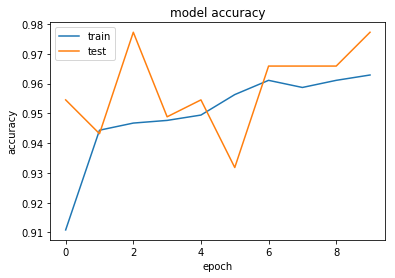

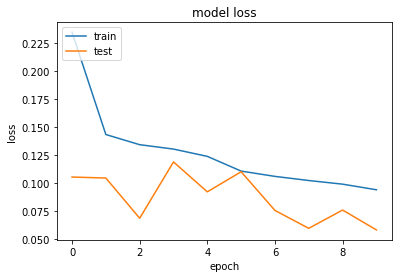

In [56]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [63]:
predictions = model.predict([xTest])
predictions = list(np.argmax(predictions[x]) for x in range(len(predictions)))

In [64]:
count = 0
length = len(yTest)
for x in range(length):
    if int(yTest[x]) != int(np.array(predictions)[x]):
        count += 1
print (str(count/length * 100) + "%")

3.225806451612903%
